In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, minmax_scale
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sys 
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.utils import np_utils
import tensorflow as tf
#from keras.regularizers import L1L2
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.utils import shuffle
#from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from featurewiz import featurewiz
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.feature_selection import mutual_info_classif
np.random.seed(19680801)

Imported version = 0.1.70.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                


In [2]:
def train(x_train):
    
    
  
    y_train = x_train['class']
    
    x_train = x_train.drop(['class','cluster','year','n','pct_dusted_ccn','pct_dusted_rmcl',
                           'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                           'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','n_clusts_90_anc'
                           ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                           ], axis = 1)
    
    x_train[['pct_of_biggest_anc','pct_is_newish','wrcr']] = minmax_scale(x_train[[
    'pct_of_biggest_anc','pct_is_newish','wrcr']])
    
    
    '''
    x_train[['wrcr','rcr_hi','rcr_mid','n_biggest_anc','n_secbiggest_anc','n_clusts_90_anc','pct_of_biggest_anc_new']] = minmax_scale(x_train[['wrcr','rcr_hi','rcr_mid','n_biggest_anc','n_secbiggest_anc','n_clusts_90_anc','pct_of_biggest_anc_new']])
    x_train = x_train.drop(['cluster','year','n','pct_is_newish','pct_dusted_ccn','pct_dusted_rmcl','biggest_anc','pct_in_biggest_anc','pct_of_biggest_anc','pct_of_biggest_anc_new','pct_of_biggest_anc_newish','secbiggest_anc'], axis = 1)#$%
    #x_train = x_train.drop(['pct_of_biggest_anc_new','pct_of_secbiggest_anc_new','animal','pct_is_newish'], axis = 1)
    x_train = x_train.drop(['pct_in_secbiggest_anc','pct_of_secbiggest_anc','pct_of_secbiggest_anc_newish','rcr_low','cited_by_clin','class'], axis = 1)
    '''
    
    y_train = np.array(y_train)
 
    model = LogisticRegression(random_state=0, C = 1).fit(x_train,y_train) ##logistioc
    
    '''crossvalidation2(x_train, y_train)
    print(model.intercept_, model.coef_, model.score(x_train, y_train))'''
    scores = cross_val_score(model, x_train, y_train, cv=20,scoring = "f1")
    print("cv score ", scores.mean())
    return model

exem = pd.read_csv("gold_with_pivotal.csv")
exem = exem.dropna(subset=['exemplar_cl']) 
exem['exemplar_year'] = exem['exemplar_year'].astype(int)
exem['exemplar_cl'] = exem['exemplar_cl'].astype(int)
#exem = exem[exem['exemplar_year'] < 2021]
prediction = []
for ind in exem.index:
    yr = int(exem['exemplar_year'][ind])
    cl = int(exem['exemplar_cl'][ind])
    
    x_train = pd.read_csv("data_84.csv")
    x_test = pd.read_csv("~/Documents/PhD/project_nobel/boty/boty_dccites/features_prediction_"+str(yr)+".csv")
    x_test = x_test.dropna(axis=0)
    
    x_test = x_test[x_test['n'] > 100]
    
    print("len of xtest ",len(x_test))
       
    copy_test = x_test.copy()
    x_test = x_test.drop(['prediction','cluster','year','n',
                               'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                               'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','n_clusts_90_anc'
                               ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                               ], axis = 1)
    
    x_test[['pct_of_biggest_anc','pct_is_newish','wrcr']] = minmax_scale(x_test[[
    'pct_of_biggest_anc','pct_is_newish','wrcr']])
    
    
    print("hdhdhd before ",len(x_train))
    x_train = x_train[x_train['year'] != yr]
    x_train = x_train[x_train['n'] > 100]

    
    #x_train = x_train[x_train['is_research_article'] > 0.75]
    print('len of xtrain ', len(x_train))

    model = train(x_train)
    
    pred = model.predict(x_test)
    print(pred.shape)
    #print(np.sum(pred))
    print("no of positive ",np.count_nonzero(pred == 1))
    

    
    predy = model.predict_proba(x_test)
    pred_test = []
    for i in range(predy.shape[0]):
        if predy[i][0] >= predy[i][1]:
            #pred_test.append(0.00)
            pred_test.append(predy[i][1])
        else:
            pred_test.append(predy[i][1])
    
    predy = pd.DataFrame(predy, columns = ['col_0','col_1'])
    predy = predy[predy['col_1'] > 0.75]
    #print("len of df ", len(df))
    print("len of predy ", len(predy))
    copy_test['pred_log'] = pred_test
    
    a = copy_test[copy_test['cluster'] == cl]
    if len(a) == 0:
        prediction.append(-1)
        continue
    a = a.to_numpy()
    prediction.append(a[0][np.shape(a)[1] - 1])
exem['pred'] = prediction
#exem.to_csv("exemplar_prediction.csv", index = False)

len of xtest  8646
hdhdhd before  239
len of xtrain  224
cv score  0.713105228105228
(8646,)
no of positive  1569
len of predy  320
len of xtest  8646
hdhdhd before  239
len of xtrain  224
cv score  0.713105228105228
(8646,)
no of positive  1569
len of predy  320
len of xtest  9446
hdhdhd before  239
len of xtrain  220
cv score  0.7078330003330002
(9446,)
no of positive  1564
len of predy  284
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv score  0.7222793872793872
(11109,)
no of positive  1721
len of predy  245
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv score  0.7222793872793872
(11109,)
no of positive  1721
len of predy  245
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv score  0.7222793872793872
(11109,)
no of positive  1721
len of predy  245
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv score  0.7222793872793872
(11109,)
no of positive  1721
len of predy  245
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv sc

cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10172
hdhdhd before  239
len of xtrain  203
cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10172
hdhdhd before  239
len of xtrain  203
cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10172
hdhdhd before  239
len of xtrain  203
cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  9727
hdhdhd before  239
len of xtrain  236
cv score  0.7146098346098346
(9727,)
no of positive  1891
len of predy  465
len of xtest  6099
hdhdhd before  239
len of xtrain  232
cv score  0.7169014319014317
(6099,)
no of positive  1313
len of predy  365
len of xtest  6393
hdhdhd before  239
len of xtrain  232
cv score  0.7166983016983017
(6393,)
no of positive  1639
len of predy  514
len of xtest  9768
hdhdhd before  239
len of xtrain  216
cv score  0.7010553335553336
(9768,)
no of positive  1443
len 

cv score  0.7027400377400378
(12799,)
no of positive  1618
len of predy  277
len of xtest  11498
hdhdhd before  239
len of xtrain  213
cv score  0.7167948717948718
(11498,)
no of positive  1611
len of predy  273
len of xtest  11498
hdhdhd before  239
len of xtrain  213
cv score  0.7167948717948718
(11498,)
no of positive  1611
len of predy  273
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1

cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10561
hdhdhd before  239
len of xtrain  215
cv score  0.7187445887445887
(10561,)
no of positive  1703
len of predy  289
len of xtest  10561
hdhdhd before  239
len of xtrain  215
cv score  0.7187445887445887
(10561,)
no of positive  1703
len of predy  289
len of xtest  10561
hdhdhd before  239
len of xtrain  215
cv score  0.7187445887445887
(10561,)
no of positive  1703
len of predy  289
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv score  0.7222793872793872
(11109,)
no of positive  1721
len of predy  245
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv score  0.7222793872793872
(11109,)
no of positive  1721
len of predy  245
len of xtest  13482
hdhdhd before  239
len of xtrain  228
cv score  0.728942723942724
(13482,)
no of positive  2072
len of predy  403
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv score  0.7222793872793872
(11109,)
no of positive  17

cv score  0.7193228993228993
(11921,)
no of positive  1918
len of predy  340
len of xtest  11921
hdhdhd before  239
len of xtrain  223
cv score  0.7193228993228993
(11921,)
no of positive  1918
len of predy  340
len of xtest  9768
hdhdhd before  239
len of xtrain  216
cv score  0.7010553335553336
(9768,)
no of positive  1443
len of predy  233
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  9768
hdhdhd before  239
len of xtrain  216
cv score  0.7010553335553336
(9768,)
no of positive  1443
len of predy  233
len of xtest  9768
hdhdhd before  239
len of xtrain  216
cv score  0.7010553335553336
(9768,)
no of positive  1443
le

cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10172
hdhdhd before  239
len of xtrain  203
cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10172
hdhdhd before  239
len of xtrain  203
cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10172
hdhdhd before  239
len of xtrain  203
cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10172
hdhdhd before  239
len of xtrain  203
cv score  0.7113536463536463
(10172,)
no of positive  1393
len of predy  232
len of xtest  10561
hdhdhd before  239
len of xtrain  215
cv score  0.7187445887445887
(10561,)
no of positive  1703
len of predy  289
len of xtest  10561
hdhdhd before  239
len of xtrain  215
cv score  0.7187445887445887
(10561,)
no of positive  1703
len of predy  289
len of xtest  11109
hdhdhd before  239
len of xtrain  218
cv score  0.7222793872793872
(11109,)
no of positive  1

cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1669
len of predy  300
len of xtest  12345
hdhdhd before  239
len of xtrain  222
cv score  0.7454523254523254
(12345,)
no of positive  1

384
-1  8
243
0.6462765957446809


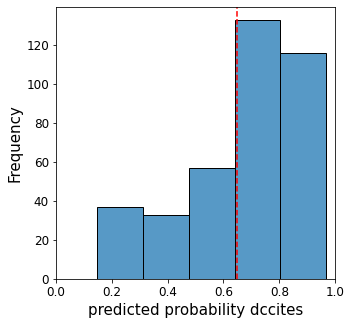

In [3]:
print(len(exem))
f = exem[exem['pred'] == -1]
print("-1 ",len(f))
d = exem[exem['pred'] > 0.65]
print(len(d))
print(len(d)/(len(exem) - len(f)))

fig = plt.figure(figsize=(5,5))
ax = sns.histplot(data = exem,x='pred', bins = 12)
plt.xlabel('predicted probability dccites', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim([0,1])
plt.axvline(x = 0.65, color = "red", ls="--")
plt.show()
fig.savefig('fig_exemplar_dccites.png')